# Analysis of An $AR(1)$ Model in pyMC3

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.6


Consider the following AR(1) process, initialized in the
infinite past:
$$
   y_t = \theta y_{t-1} + \epsilon_t,
$$
where $\epsilon_t \sim iid{\cal N}(0,1)$.  Suppose you'd like to learn about $\theta$ from a a sample of observations $Y^T = \{ y_0, y_1,\ldots, y_T \}$.

First, let's generate our sample.

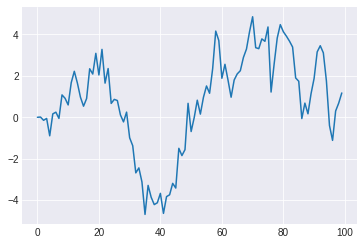

In [2]:
np.random.seed(seed=1848)

T = 100
y = np.zeros((T,))

for i in range(1,T):
    y[i] = 0.95 * y[i-1] + np.random.normal()

plt.plot(y);

Consider the following prior for $\theta$: $\theta \sim {\cal N}(0,\tau^2)$.
We can show that the posterior distribution of $\theta$ is of the form

$$
 \theta |Y^T \sim {\cal N}( \tilde{\theta}_T, \tilde{V}_T),
$$

where

$$
\begin{eqnarray}
        \tilde{\theta}_T &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1} \sum_{t=1}^T y_{t}y_{t-1} \\
        \tilde{V}_T      &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1}
\end{eqnarray}
$$

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta]


Sampling 4 chains:   0%|          | 0/6000 [00:00<?, ?draws/s]

Sampling 4 chains:  13%|█▎        | 775/6000 [00:00<00:00, 7746.89draws/s]

Sampling 4 chains:  29%|██▉       | 1726/6000 [00:00<00:00, 8200.92draws/s]

Sampling 4 chains:  46%|████▌     | 2756/6000 [00:00<00:00, 8733.66draws/s]

Sampling 4 chains:  63%|██████▎   | 3788/6000 [00:00<00:00, 9155.10draws/s]

Sampling 4 chains:  80%|████████  | 4816/6000 [00:00<00:00, 9465.64draws/s]

Sampling 4 chains:  94%|█████████▍| 5646/6000 [00:00<00:00, 7418.74draws/s]

Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 7566.11draws/s]


The acceptance probability does not match the target. It is 0.8859800580278703, but should be close to 0.8. Try to increase the number of tuning steps.


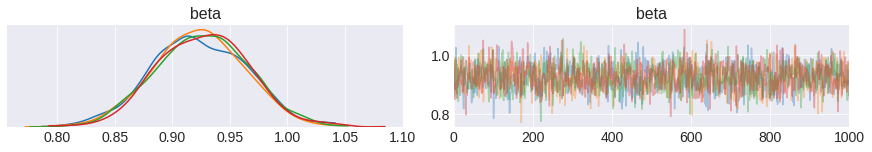

In [3]:
tau = 1.0
with pm.Model() as ar1:
    beta = pm.Normal('beta', mu=0, sigma=tau)
    data = pm.AR('y', beta, sigma=1.0, observed=y)
    trace = pm.sample(1000, cores=4)
    
pm.traceplot(trace);

In [4]:
mup = ((y[:-1]**2).sum() + tau**-2)**-1 * np.dot(y[:-1],y[1:])
Vp =  ((y[:-1]**2).sum() + tau**-2)**-1
print('Mean: {:5.3f} (exact = {:5.3f})'.format(trace['beta'].mean(), mup))
print('Std: {:5.3f} (exact = {:5.3f})'.format(trace['beta'].std(), np.sqrt(Vp)))

Mean: 0.924 (exact = 0.925)
Std: 0.040 (exact = 0.040)


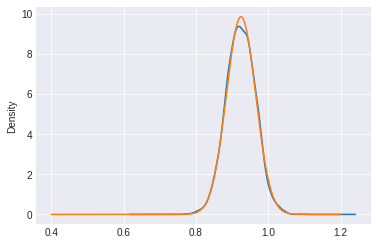

In [5]:
import pandas as p
from scipy.stats import norm
ax=p.Series(trace['beta']).plot(kind='kde')
xgrid = np.linspace(0.4, 1.2, 1000)
fgrid = norm(loc=mup, scale=np.sqrt(Vp)).pdf(xgrid)
ax.plot(xgrid,fgrid);

## Extension to AR(p)
We can instead estimate an AR(2) model using pyMC3.
$$
 y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t.
$$
The `AR` distribution infers the order of the process by size the of `rho` argmument passed to `AR`. 

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta]


Sampling 4 chains:   0%|          | 0/6000 [00:00<?, ?draws/s]

Sampling 4 chains:   8%|▊         | 453/6000 [00:00<00:01, 4522.41draws/s]

Sampling 4 chains:  16%|█▋        | 978/6000 [00:00<00:01, 4716.98draws/s]

Sampling 4 chains:  25%|██▌       | 1525/6000 [00:00<00:00, 4918.45draws/s]

Sampling 4 chains:  35%|███▍      | 2088/6000 [00:00<00:00, 5112.11draws/s]

Sampling 4 chains:  45%|████▍     | 2698/6000 [00:00<00:00, 5372.47draws/s]

Sampling 4 chains:  55%|█████▍    | 3293/6000 [00:00<00:00, 5531.46draws/s]

Sampling 4 chains:  65%|██████▍   | 3873/6000 [00:00<00:00, 5608.12draws/s]

Sampling 4 chains:  75%|███████▍  | 4474/6000 [00:00<00:00, 5719.10draws/s]

Sampling 4 chains:  84%|████████▍ | 5068/6000 [00:00<00:00, 5781.95draws/s]

Sampling 4 chains:  94%|█████████▍| 5631/6000 [00:01<00:00, 5596.92draws/s]

Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4796.93draws/s]


The number of effective samples is smaller than 25% for some parameters.


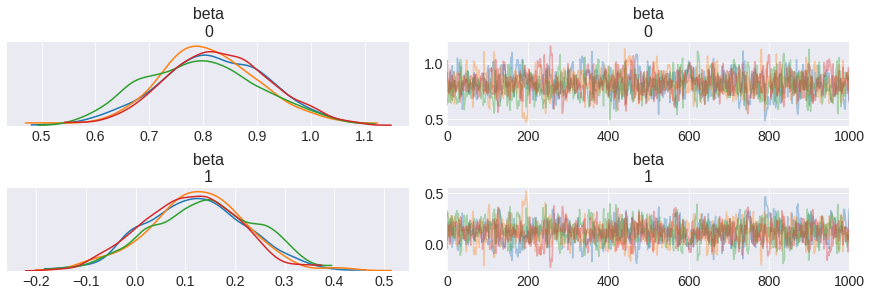

In [6]:
with pm.Model() as ar2:
    beta = pm.Normal('beta', mu=0, sigma=tau, shape=2)
    data = pm.AR('y', beta, sigma=1.0, observed=y)
    trace = pm.sample(1000, cores=4)
    
pm.traceplot(trace);

You can also pass the set of AR parameters as a list. 

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta2, beta]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 195/8000 [00:00<00:04, 1949.38draws/s]

Sampling 4 chains:   6%|▋         | 516/8000 [00:00<00:03, 2209.64draws/s]

Sampling 4 chains:  11%|█▏        | 900/8000 [00:00<00:02, 2531.41draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [00:00<00:02, 2902.11draws/s]

Sampling 4 chains:  22%|██▏       | 1777/8000 [00:00<00:01, 3223.85draws/s]

Sampling 4 chains:  28%|██▊       | 2271/8000 [00:00<00:01, 3595.75draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [00:00<00:01, 3701.20draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [00:00<00:01, 3824.00draws/s]

Sampling 4 chains:  44%|████▍     | 3559/8000 [00:00<00:01, 4060.26draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [00:01<00:00, 4099.28draws/s]

Sampling 4 chains:  55%|█████▍    | 4397/8000 [00:01<00:00, 3927.64draws/s]

Sampling 4 chains:  60%|██████    | 4802/8000 [00:01<00:00, 3957.29draws/s]

Sampling 4 chains:  65%|██████▌   | 5208/8000 [00:01<00:00, 3984.23draws/s]

Sampling 4 chains:  70%|███████   | 5610/8000 [00:01<00:00, 3817.21draws/s]

Sampling 4 chains:  75%|███████▍  | 5996/8000 [00:01<00:00, 3566.87draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [00:01<00:00, 3817.85draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [00:01<00:00, 3982.60draws/s]

Sampling 4 chains:  92%|█████████▏| 7326/8000 [00:01<00:00, 4069.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7740/8000 [00:01<00:00, 3934.05draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3822.77draws/s]


The acceptance probability does not match the target. It is 0.7077017394179166, but should be close to 0.8. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


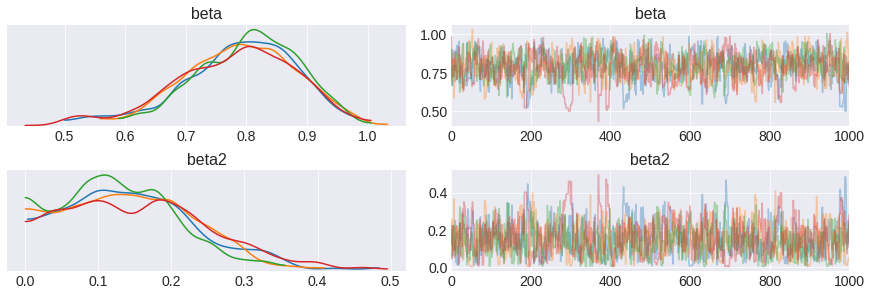

In [7]:
with pm.Model() as ar2:
    beta = pm.Normal('beta', mu=0, sigma=tau)
    beta2 = pm.Uniform('beta2')
    data = pm.AR('y', [beta, beta2], sigma=1.0, observed=y)
    trace = pm.sample(1000, tune=1000, cores=4)

pm.traceplot(trace);